In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

# Generating the Dataset

In [2]:
max_degree = 20  # maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate losts of empty spaces
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1)  # `gamma(n)` = (n-1)!
# Shape of `label`: (`n_train` + `n_test`,)    
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)


In [3]:
# Convert NumPy ndarrays to tensors
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]
]
features[:2], poly_features[:2, :], labels[:2] 

(tensor([[-0.2556],
         [-2.3333]]),
 tensor([[ 1.0000e+00, -2.5558e-01,  3.2661e-02, -2.7825e-03,  1.7779e-04,
          -9.0878e-06,  3.8711e-07, -1.4134e-08,  4.5155e-10, -1.2823e-11,
           3.2773e-13, -7.6147e-15,  1.6218e-16, -3.1885e-18,  5.8208e-20,
          -9.9180e-22,  1.5843e-23, -2.3818e-25,  3.3819e-27, -4.5492e-29],
         [ 1.0000e+00, -2.3333e+00,  2.7222e+00, -2.1172e+00,  1.2350e+00,
          -5.7634e-01,  2.2413e-01, -7.4709e-02,  2.1790e-02, -5.6492e-03,
           1.3181e-03, -2.7960e-04,  5.4366e-05, -9.7579e-06,  1.6263e-06,
          -2.5298e-07,  3.6892e-08, -5.0636e-09,  6.5638e-10, -8.0608e-11]]),
 tensor([  4.5078, -18.9481]))

# Training and Testing the Model

In [4]:
def evaluate_loss(net, data_iter, loss): #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2) # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_featurers, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_featurers.shape[-1]
    # Switch off the bias since we already catered for it in polynomial featurers.
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_featurers, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                           legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch+1) % 20 == 0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

# Third-Order Polynomial Function Fitting (Normal)

weight: [[ 5.047921   1.3100227 -3.5657437  5.224172 ]]


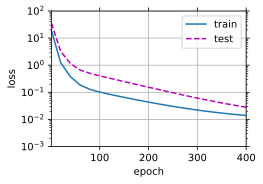

In [6]:
# Pick the first four dimensions, i.e. 1, x, x^2/2!, x^3/3! from the polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

# Linear Function Fitting (Underfitting)

weight: [[3.7136097 4.3565693]]


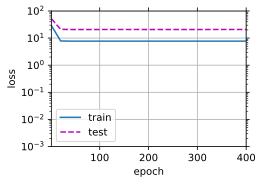

In [7]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

# Higher-Order Polynomial Function Fitting (Overfitting)

weight: [[ 4.9809399e+00  1.3514944e+00 -3.1988494e+00  4.8853645e+00
  -1.1405463e+00  8.8793796e-01 -1.6411369e-03  1.2706619e-02
   1.6486837e-01  6.3584171e-02 -1.5051173e-01 -2.1813804e-01
   5.0025579e-02  1.1617547e-01 -4.6178874e-02  2.3978736e-02
   5.5996865e-02 -1.4287274e-01 -4.6025321e-02  1.6151956e-01]]


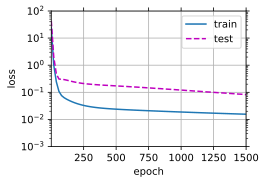

In [8]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)